<a href="https://colab.research.google.com/github/SLVmain/NLP/blob/Les_02/HW_02_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Домашка 2. Тема «Создание признакового пространства»

### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.


### Задание 2.

найти фичи с наибольшей значимостью, и вывести их


### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings 
warnings.filterwarnings('ignore')
import os
import time

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from collections import Counter

import nltk
import html

from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk import tokenize as tknz
from nltk.corpus import stopwords

#nltk.download('genesis')
#nltk.download('punkt')

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [3]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = 'positive'
positive.tail()

,text,label
114906,"Спала в родительском доме, на своей кровати... Проснулась с кошкой на голове))",positive
114907,"RT @jebesilofyt: Эх... Мы немного решили сократить путь, сейчас уже лежу в мягкой кровати :) а с отсутствием сети помогла справится какая-",positive
114908,"Что происходит со мной, когда в эфире #proactivefm звучит моя любимая песня)) #dctalk #music @… http://t.co/65KGFFd5oO",positive
114909,"""Любимая,я подарю тебе эту звезду..."" Имя какой звезды переводится ""подмышка""? ;-)",positive
114910,@Ma_che_rie посмотри #непытайтесьпокинутьомск сегодня в Вавилоне в 18.20. Я там тоже есть :),positive


In [4]:
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = 'negative'
df = positive.append(negative)
df.sample(5)

,text,label
19154,"Блииин , ну почему??? \nПочему же мне так не везет...\nНастроение испорчено (",negative
77323,@maria_glushko после того домой еще сильнее хочется :(,negative
20281,RT @robipyka: Что-то моя Мандрива не дээнэсит =(,negative
74374,"Я, конечно, сама всё испортила. Но думать, что он козел, гораздо приятнее...)))",positive
22449,оооооооооооо да это про меня либо одеяло либо насморк) http://t.co/8yLgOoGVMh,positive


In [5]:
df.describe()

,text,label
count,226834,226834
unique,217440,2
top,"Офигенный день!\nдень позитива)\nбегал как идиот целый день!\nтанцы офигенны, хоть я и ракал но мне очень понравилось!",positive
freq,156,114911


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226834 entries, 0 to 111922
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    226834 non-null  object
 1   label   226834 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


<AxesSubplot:>

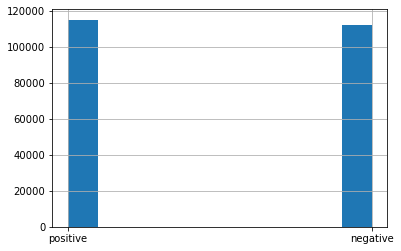

In [7]:
df['label'].hist()

In [87]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label, train_size=0.7, 
                                                    random_state=42)

<AxesSubplot:>

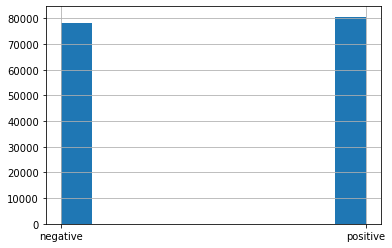

In [9]:
y_train.hist()

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stwrd = stopwords.words('russian')
stwrd[:5],stwrd[-5:] 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SR_Ad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(['и', 'в', 'во', 'не', 'что'], ['более', 'всегда', 'конечно', 'всю', 'между'])

In [13]:
noise =  list(punctuation) + stwrd

In [14]:
noise[-3:], noise[:3]

(['конечно', 'всю', 'между'], ['!', '"', '#'])

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.77, # встречается не менее чем в 70% документов
                             min_df=0.001, # встречается менее чем 0.1 % докуменов 
                             stop_words=noise, #исключим знаки препинания и стоп слова
                             token_pattern='[A-Za-zа-яА-Я][A-Za-zа-яА-Я]+' # не менее двух букв в начале слова и + ...
                             ) 

In [16]:
words_bag = tfidf_vectorizer.fit_transform(x_train)

In [17]:
feature_names = tfidf_vectorizer.get_feature_names()
feature_names[:5], feature_names[-5:], len(feature_names), 'конечно' in feature_names, '@' in feature_names

(['alex', 'alina', 'anna', 'cio', 'co'],
 ['этих', 'это', 'этому', 'эх', 'января'],
 894,
 False,
 False)

In [18]:
len(tfidf_vectorizer.idf_)

894

In [19]:
df_test = pd.DataFrame(words_bag.toarray(), columns = feature_names)
df_test.sample(5)

,alex,alina,anna,cio,co,crazy,dasha,dd,ddd,die,do,ff,fm,follow,gt,http,https,in,is,julia,ka,kate,kill,love,lt,mars,me,mr,my,nastya,of,on,one,optimal,or,rt,ru,teamfollowback,the,to,tukvasociopat,ya,you,ааа,аааа,ааааа,ага,аж,английский,ах,ахах,ахаха,ахахах,ахахаха,ахахахах,бабушка,безумно,бесит,бл,блиин,блин,бля,блять,боже,болеть,болею,болит,боль,больницу,больно,большое,большой,боюсь,брат,будем,будешь,буду,будут,будь,бывает,быстрее,быстро,вами,ваще,везде,верю,весело,весь,вечер,вечера,вечером,вечно,вещи,взять,видел,видела,видео,видеть,видимо,видно,вижу,вк,вместе,вместо,возможно,вокруг,волосы,вообще,вопрос,вопросы,воскресенье,впервые,времени,время,вроде,вромайдан,вс,всей,всем,вспомнила,вставать,встала,встать,вся,второй,вчера,выздоравливай,выспалась,выходные,выходных,вышла,главное,глаз,глаза,го,говно,говорил,говорила,говорит,говорить,говорю,говорят,год,года,годом,году,голова,голове,голову,голос,горло,город,городе,господи,гости,готова,грустно,гулять,даа,дааа,давай,давайте,давно,дай,далеко,дали,дальше,две,двух,девочка,девочки,девушка,девушки,действительно,декабря,дела,делает,делаешь,делать,делаю,деле,дело,денег,день,деньги,детей,дети,дн,дней,днем,дни,дня,добра,доброго,доброе,добрый,дождь,долго,должен,должна,должно,должны,дом,дома,домой,др,друг,друга,другие,друзей,друзья,думал,думала,думать,думаю,дура,душе,души,еду,елку,ем,ехать,ещ,жалко,жаль,ждать,ждем,жду,желание,желаю,женщина,жесть,живу,жизни,жизнь,жить,жопа,жуйк,жутко,заболела,забыл,забыла,забыть,завтра,закончился,зато,зачет,збс,здорово,зима,зимой,зиму,знает,знаете,знаешь,знал,знала,знать,значит,знаю,зря,ибо,играет,играть,игры,ид,идет,иди,идиот,идти,иду,именно,имя,иначе,интересно,интернет,истории,историю,история,итоге,ка,каждый,кажется,какие,какого,какое,какую,каникулы,капец,кароч,каток,кем,кино,класс,классе,классно,классный,ко,кого,кое,кому,конец,конца,конце,концерт,короче,кот,которая,которого,которой,которые,который,которых,кофе,кошмар,красивая,красиво,кровати,кроме,круто,крутой,кстати,купил,купила,купить,куча,кушать,ладно,лента,ленте,ленту,лень,лет,лето,летом,либо,лицо,лишь,лол,лох,лучшая,лучшие,лучший,любви,любимая,любимого,любимой,любимые,любимый,любит,любить,любишь,люблю,любовь,любят,людей,люди,людям,магазин,маленькая,маленький,мало,мальчик,мама,маме,мамой,мать,меньше,места,месте,место,месяц,месяца,метро,милая,мило,милый,минут,мир,мире,ммм,многие,мной,мо,мог,могла,могу,могут,мое,моего,моей,моем,моему,можешь,мозг,мои,моим,моих,молодец,момент,мороз,москве,мою,мужик,музыка,музыку,мысли,наверно,наверное,надеюсь,надоело,назад,называется,найти,нам,нами,наоборот,написал,написала,написать,напишу,например,народ,настолько,настроение,настроения,настя,нахуй,начал,начала,начало,начать,начинается,начинаю,наш,наша,нашей,нашел,наши,нашла,нг,недавно,недели,неделю,неделя,некоторые,нем,немного,нему,ненавижу,несколько,нету,неужели,нечего,никак,никого,никому,никто,никуда,ними,новая,нового,новогоднего,новогоднее,новое,новости,новую,новые,новый,новым,ноги,номер,норм,нормально,ночи,ночь,ночью,нравится,нужен,нужна,нужно,нужны,нь,обидно,обожаю,обратно,общем,обычно,обязательно,ого,одна,одни,одно,одного,одной,одном,одну,ой,ок,оказалось,оказывается,около,оно,оо,ооо,особенно,особо,осталась,осталось,ответ,откуда,отлично,отличный,офигенный,ох,оч,очень,ощущение,папа,парень,парни,парня,пару,пары,первая,первой,первый,песни,песню,песня,печаль,печально,пздц,пиздец,пипец,писала,писать,письмо,пить,пишет,пишу,пишут,плакать,планы,платье,плачу,плохо,повезло,поговорить,погода,подарки,подарок,подруга,подряд,подумала,поеду,пожалуйста,поздно,поздравляю,пойду,пойти,пока,пол,получается,получилось,получится,помню,понедельник,понимаешь,понимаю,понравилось,понял,поняла,понятно,понять,пор,пора,последнее,последние,последний,последняя,посмотрел,посмотрела,посмотреть,постоянно,походу,похоже,почему,пошел,пошла,пошли,поэтому,ппц,правда,правильно,праздник,прекрасно,привет,прид,придется,приехал,приехала,пришел,пришла,пришли,пришлось,приятно,проблема,проблемы,происходит,проснулась,проснулся,прости,простите,просто,против,прошел,прошло

In [20]:
#оставим стоп-слова для полноты картины, чтобы все частоты были представлены

In [21]:
def tfidf_freq_analis(maxdf=1, mindf=1):
    tfidf_vectorizer = TfidfVectorizer(max_df=maxdf, 
                                 min_df=mindf,
                                 #max_features=1000, #ограничим количество слов, попадающий в мешок только верхними 
                                 #max_features, упорядоченные по частоте терминов в корпусе.
                                 #stop_words=noise, #исключим 
                                 token_pattern='[A-Za-zа-яА-Я][A-Za-zа-яА-Я]+'
                             ) 
    words_bag = tfidf_vectorizer.fit_transform(x_train)
    clf = LogisticRegression(random_state=42)
    clf.fit(words_bag, y_train)
    pred = clf.predict(tfidf_vectorizer.transform(x_test))
    tfidf_vectorizer.idf_
    print(f'max_df= {maxdf} min_df= {mindf}')
    print(classification_report(pred, y_test))
    return tfidf_vectorizer, clf

In [22]:
params = {'default все токены':[1,1], 'высокая частота': [1.0,0.2], 
          'средняя частота': [0.75, 0.08], 'низкая частота': [0.5, 1]} # (max, min)

In [23]:
tfidf_vec = None
model_LR = None

for key, value in params.items():
    print(key)
    tfidf_vec, model_LR = tfidf_freq_analis(value[0], value[1])

default все токены
max_df= 1 min_df= 1
              precision    recall  f1-score   support

    negative       0.14      0.56      0.22      8239
    positive       0.90      0.51      0.65     59812

    accuracy                           0.52     68051
   macro avg       0.52      0.54      0.44     68051
weighted avg       0.80      0.52      0.60     68051

высокая частота
max_df= 1.0 min_df= 0.2
              precision    recall  f1-score   support

    negative       0.35      0.61      0.44     19506
    positive       0.78      0.55      0.64     48545

    accuracy                           0.56     68051
   macro avg       0.56      0.58      0.54     68051
weighted avg       0.65      0.56      0.59     68051

средняя частота
max_df= 0.75 min_df= 0.08
              precision    recall  f1-score   support

    negative       0.46      0.59      0.52     26415
    positive       0.69      0.57      0.62     41636

    accuracy                           0.58     68051
   macr

### Низкочастотные токены лучше характеризуют документ

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [24]:
feature_names = tfidf_vec.get_feature_names()

In [49]:
#'хочупровестиновогоднююночьвместес' in feature_names

True

In [25]:
importance = model_LR.coef_
importance

array([[ 0.31107294, -0.09517882, -0.40200875, ..., -0.43589796,
         0.08272703, -0.18025035]])

In [42]:
linx_max = []
temp = np.abs(importance.copy()[0])
for i in range (0,100):
    inx_max = np.argmax(temp)
    linx_max.append(inx_max)
    print(inx_max, temp[inx_max],  feature_names[inx_max])
    temp[inx_max] = 0

inx 14380 10.075289458295492 dd
inx 14388 8.093722484608383 ddd
inx 155638 7.537174817161441 обидно
inx 118095 6.892287444699684 жаль
inx 194015 6.729717879707069 скучаю
inx 109889 6.211269364016728 грустно
inx 118061 6.158190972692083 жалко
inx 166469 6.082569737594943 печально
inx 90799 5.7311384729300325 ахах
inx 166450 5.503871848894281 печаль
inx 58589 5.421826837268215 prisonero
inx 90822 5.375150751879533 ахахах
inx 196321 5.352628655226612 сожалению
inx 197773 5.325741229689901 спасибо
inx 94874 5.311234241807146 блин
inx 90801 5.247990297402983 ахаха
inx 95802 5.126281095716591 боль
inx 194003 5.118607520395273 скучать
inx 150957 5.101952691789013 не
inx 179207 5.046531567957547 приятно
inx 209012 5.009928743232968 ужасно
inx 119731 4.871509782263993 заболела
inx 14389 4.832367214112508 dddd
inx 152165 4.755796525785475 ненавижу
inx 54818 4.7357428855925265 optimal
inx 11596 4.638831149835098 cio
inx 81175 4.608228199583027 xd
inx 208995 4.582979745884018 ужас
inx 156221 4.470

Оценим, какие label  есть в  df с best_fe в твитах.

In [45]:
for inx in linx_max[3:5]:
    print(feature_names[inx], end ='  ')
    pos_neg = [0,0]
    for tweet, label in zip(df.text, df.label):
        #print(tweet, label)
        for token in word_tokenize(tweet):
            #print('token', token, feature_names[linx_max[2]])
            if token == feature_names[inx]:
                #print(feature_names[linx_max[2]])
                if label == 'positive':
                    pos_neg[0] = pos_neg[0] + 1
                   # print(0)
                if label == 'negative':
                    pos_neg[1] = pos_neg[1] + 1
                    #print(1)
    print(pos_neg)

жаль  [160, 995]
скучаю  [159, 930]


In [52]:
print('ахах', end ='  ')
pos_neg = [0,0]
for tweet, label in zip(df.text, df.label):
        #print(tweet, label)
        for token in word_tokenize(tweet):
            #print('token', token, feature_names[linx_max[2]])
            if token == 'ахах':
                #print(feature_names[linx_max[2]])
                if label == 'positive':
                    pos_neg[0] = pos_neg[0] + 1
                   # print(0)
                if label == 'negative':
                    pos_neg[1] = pos_neg[1] + 1
                    #print(1)
print(pos_neg)

ахах  [1161, 238]


In [53]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [54]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

In [55]:
for t in linx_max:
    print(feature_names[t], freq_dict[feature_names[t]])

dd 0
ddd 0
обидно 700
жаль 1155
скучаю 1089
грустно 601
жалко 794
печально 339
ахах 1399
печаль 317
prisonero 0
ахахах 793
сожалению 376
спасибо 2617
блин 2780
ахаха 1102
боль 428
скучать 364
не 69472
приятно 801
ужасно 758
заболела 360
dddd 1
ненавижу 548
optimal 0
cio 0
xd 1
ужас 369
обожаю 366
увы 251
жизньболь 190
опять 2047
сочувствую 143
хочу 6137
болит 1263
kill 3
устала 502
почему 2741
obnulyay 0
рада 538
умер 297
грустный 127
нету 665
ржу 128
бля 1016
боюсь 654
or 2
хаха 277
oppa 0
плохо 1749
ахахаха 370
мило 337
больно 523
бедный 114
do 9
ахахахах 233
наконец 371
хахаха 147
нет 7078
печалька 86
поздравляю 240
ура 233
говно 326
скучно 815
ooo 0
horanso 0
lponomarenko 0
кошмар 152
хочупровестиновогоднююночьвместес 0
весело 618
потеряла 191
плакать 305
эх 530
ужасное 161
пздц 239
тяжело 290
пропустила 172
блииин 132
придется 499
бедная 92
пичаль 54
счастлива 207
прости 506
снегу 207
забавно 93
главное 627
oo 0
вполне 124
снаступающимтвиттерский 0
каникулы 512
нельзя 965
классно 

## ВЫВОД: Странный результат, нужны Ваши комментарии, откуда 0-е  значения ?

### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [89]:
from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import accuracy_score

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)


count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(x_train)

xtrain_count =  count_vect.transform(x_train)
xtest_count =  count_vect.transform(x_test)

classifier = linear_model.LogisticRegression()
classifier.fit(xtrain_count, y_train)
predictions = classifier.predict(xtest_count)
#predictions
print(accuracy_score(y_test, predictions))
print(classification_report(predictions, y_test))

0.7825454438582827
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     34740
           1       0.77      0.79      0.78     33311

    accuracy                           0.78     68051
   macro avg       0.78      0.78      0.78     68051
weighted avg       0.78      0.78      0.78     68051



In [90]:
tf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_df=0.3)
tf_vect.fit(x_train)

xtrain_count =  tf_vect.transform(x_train)
xtest_count =  tf_vect.transform(x_test)

classifier = linear_model.LogisticRegression()
classifier.fit(xtrain_count, y_train)
predictions = classifier.predict(xtest_count)
#predictions
print(accuracy_score(y_test, predictions))
print(classification_report(predictions, y_test))

0.7811347371824073
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     33772
           1       0.78      0.78      0.78     34279

    accuracy                           0.78     68051
   macro avg       0.78      0.78      0.78     68051
weighted avg       0.78      0.78      0.78     68051



In [112]:
from sklearn.feature_extraction.text import HashingVectorizer
list_ = [128 , 512, 2048, 4096]
for i in list_:
    h_vect = HashingVectorizer(n_features=i)
    h_vect.fit(x_train)

    xtrain_count =  h_vect.transform(x_train)
    xtest_count =  h_vect.transform(x_test)

    classifier = linear_model.LogisticRegression()
    classifier.fit(xtrain_count, y_train)
    predictions = classifier.predict(xtest_count)
    #predictions
    print(f'размер вектора hash= {i}')
    print(accuracy_score(y_test, predictions))
    print(classification_report(predictions, y_test))

размер вектора hash= 128
0.5930258188711408
              precision    recall  f1-score   support

           0       0.57      0.59      0.58     32287
           1       0.62      0.59      0.60     35764

    accuracy                           0.59     68051
   macro avg       0.59      0.59      0.59     68051
weighted avg       0.59      0.59      0.59     68051

размер вектора hash= 512
0.6342595994180835
              precision    recall  f1-score   support

           0       0.61      0.64      0.62     32389
           1       0.66      0.63      0.64     35662

    accuracy                           0.63     68051
   macro avg       0.63      0.63      0.63     68051
weighted avg       0.64      0.63      0.63     68051

размер вектора hash= 2048
0.6721723413322361
              precision    recall  f1-score   support

           0       0.66      0.67      0.66     32841
           1       0.69      0.67      0.68     35210

    accuracy                           0.67     6

In [113]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model

In [114]:
y_train = np.expand_dims(y_train, axis=1) 
y_test = np.expand_dims(y_test, axis=1)
xtrain_count.shape, y_train.shape, y_test.shape

((158783, 4096), (158783, 1, 1), (68051, 1, 1))

In [115]:
input_layer = Input(shape=(xtrain_count.shape[1],))
dense_layer_1 = Dense(1024, activation='relu')(input_layer)
dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
output = Dense(1, activation='softmax')(dense_layer_2)

In [116]:
model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [117]:
print(model.summary())

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_18 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 4,720,641
Trainable params: 4,720,641
Non-trainable params: 0
_________________________________________________________________
None


## Что то пошло не так.... Нужна Ваша помощь

In [123]:
history = model.fit(xtrain_count.toarray(), y_train, batch_size=8, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
15879/15879 [==============================] - 360s 23ms/step - loss: 0.0000e+00 - acc: 0.5073 - val_loss: 0.0000e+00 - val_acc: 0.5091
Epoch 2/50
15879/15879 [==============================] - 361s 23ms/step - loss: 0.0000e+00 - acc: 0.5073 - val_loss: 0.0000e+00 - val_acc: 0.5091
Epoch 3/50
15879/15879 [==============================] - 322s 20ms/step - loss: 0.0000e+00 - acc: 0.5073 - val_loss: 0.0000e+00 - val_acc: 0.5091
Epoch 4/50
15879/15879 [==============================] - 327s 21ms/step - loss: 0.0000e+00 - acc: 0.5073 - val_loss: 0.0000e+00 - val_acc: 0.5091
Epoch 5/50
15879/15879 [==============================] - 338s 21ms/step - loss: 0.0000e+00 - acc: 0.5073 - val_loss: 0.0000e+00 - val_acc: 0.5091
Epoch 6/50
15879/15879 [==============================] - 344s 22ms/step - loss: 0.0000e+00 - acc: 0.5073 - val_loss: 0.0000e+00 - val_acc: 0.5091
Epoch 7/50
 4531/15879 [=======>......................] - ETA: 3:42 - loss: 0.0000e+00 - acc: 0.5053

KeyboardInterrupt: 